In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# testing data

base_dir = '/content/drive/MyDrive/Pose Estimation/data/Taken'

# Function to retrieve all image paths from a directory
def get_image_paths(directory):
    # List to store paths
    image_paths = []
    # os.walk goes through all subdirectories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Check for jpeg files
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                # Construct full file path
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
    return image_paths

# Get image paths for 'sweep' and 'pull' directories
sweep_images = get_image_paths(os.path.join(base_dir, 'sweep'))
pull_images = get_image_paths(os.path.join(base_dir, 'pull'))

# Combine all image paths
all_image_paths = sweep_images + pull_images

images_to_remove = ['5.jpeg', '3pull.jpeg']

# Filter out specific images
filtered_image_paths = [path for path in all_image_paths if not any(img in path for img in images_to_remove)]

# Print remaining image paths
for path in filtered_image_paths:
    print(path)


/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/1.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/2.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/3.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/4.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/pull/4pull.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/pull/5pull.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/pull/6pull.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/pull/2pull.jpeg
/content/drive/MyDrive/Pose Estimation/data/Taken/pull/1pull.jpeg


In [ ]:
# Training Data

base_dir2 = '/content/drive/MyDrive/Pose Estimation/data/Manual'

# Function to retrieve all image paths from a directory
def get_image_paths(directory):
    # List to store paths
    image_paths = []
    # os.walk goes through all subdirectories
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Check for jpeg files
            if file.endswith(".jpeg") or file.endswith(".jpg"):
                # Construct full file path
                full_path = os.path.join(subdir, file)
                image_paths.append(full_path)
    return image_paths

# Get image paths for 'sweep' and 'pull' directories
sweep_images_t = get_image_paths(os.path.join(base_dir2, 'Sweep'))
pull_images_t = get_image_paths(os.path.join(base_dir2, 'Pull'))

# Combine all image paths
all_image_paths_t = sweep_images_t + pull_images_t

all_image_paths_t

['/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/1.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/2.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/3.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/4.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/5.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/6.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/7.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/8.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Sweep/9.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/1.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/2.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/3.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/4.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/5.jpg',
 '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/6.jpg',
 

In [ ]:
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

In [ ]:
image_path= '/content/drive/MyDrive/Pose Estimation/data/Manual/Pull/1.jpg'

In [ ]:
# Just estimate

def run_pose_estimation(image_path):
    # Load and prepare the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float values in [0, 1]

    # Resize the image to match the expected input size of MoveNet
    img = tf.image.resize(img, (192, 192))

    # Convert the image to int32 data type
    img = tf.cast(img * 255, dtype=tf.int32)

    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)

    # Run model inference
    results = movenet(input=img)  # Pass the image as 'input' argument
    keypoints = results['output_0'].numpy()

    # Display the image and keypoints
    plt.figure(figsize=(10, 10))
    plt.imshow(tf.squeeze(img).numpy())  # Remove batch dimension before plotting
    height, width, _ = img.shape[1:]  # Get height and width after removing batch dimension
    for keypoint in keypoints[0][0]:
        y, x, confidence = keypoint
        if confidence > 0.1:
            plt.plot(x * width, y * height, 'ro', markersize=5)
    plt.axis('off')
    plt.show()





In [ ]:
# Draw too

def draw_pose(image, keypoints):
    # Define the connections between keypoints to form a pose
    connections = [
        [0, 1], [0, 2], [1, 3], [2, 4],  # Upper body
        [5, 6], [5, 7], [7, 9], [6, 8],  # Lower body
        [8, 10], [5, 11], [6, 12], [11, 12],  # Arms
        [11, 13], [12, 14], [13, 15], [14, 16]  # Forearms
    ]

    # Convert image from float to uint8
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image = tf.squeeze(image)  # Remove batch dimension

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    height, width = image.shape[:2]

    # Plot keypoints
    for keypoint in keypoints[0][0]:
        y, x, confidence = keypoint
        if confidence > 0.1:  #
            plt.plot(x * width, y * height, 'ro', markersize=5)

    # Connect keypoints to visualize the pose
    for connection in connections:
        start_keypoint = keypoints[0][0][connection[0]]
        end_keypoint = keypoints[0][0][connection[1]]
        start_point = (start_keypoint[1] * width, start_keypoint[0] * height)  # Flip x and y
        end_point = (end_keypoint[1] * width, end_keypoint[0] * height)  # Flip x and y
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'g-', linewidth=2)

    plt.axis('off')
    plt.show()

def run_pose_estimation(image_path):
    # Load and prepare the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float values in [0, 1]

    # Resize the image to match the expected input size of MoveNet
    img = tf.image.resize(img, (192, 192))

    # Convert the image to int32 data type
    img = tf.cast(img * 255, dtype=tf.int32)

    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)

    # Run model inference
    results = movenet(input=img)  # Pass the image as 'input' argument
    keypoints = results['output_0'].numpy()


    # Draw pose on the image
    draw_pose(img, keypoints)


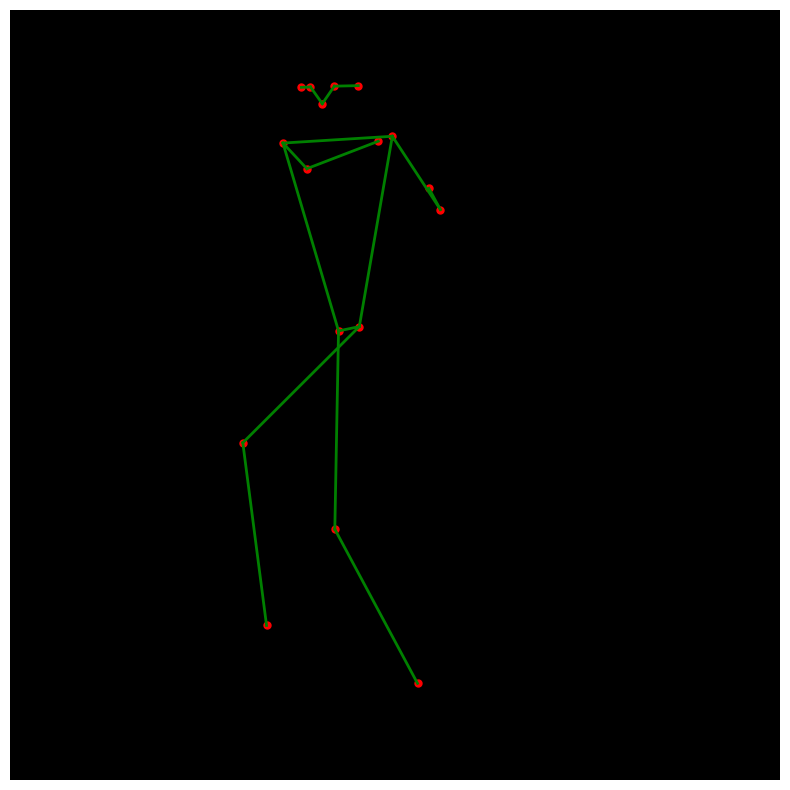

In [ ]:
run_pose_estimation(image_path)

In [ ]:
# Let's try classification:

In [ ]:
# Load the MoveNet "lightning" model from TensorFlow Hub
model = hub.load('https://tfhub.dev/google/movenet/singlepose/lightning/4')
movenet = model.signatures['serving_default']

# Function to extract keypoints from an image
def extract_keypoints(image_path):
    # Load and prepare the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode the image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert to float values in [0, 1]

    # Resize the image to match the expected input size of MoveNet
    img = tf.image.resize(img, (192, 192))

    # Convert the image to int32 data type
    img = tf.cast(img * 255, dtype=tf.int32)

    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)

    # Run model inference
    results = movenet(input=img)  # Pass the image as 'input' argument
    keypoints = results['output_0'].numpy()

    # Flatten the keypoints array
    keypoints_flat = keypoints.flatten()

    return keypoints_flat

# Example usage
# Prepare your dataset with labeled images for pull shots and sweep shots
# Replace 'image_paths_pull' and 'image_paths_sweep' with paths to your labeled images
plusp = ['/content/drive/MyDrive/Pose Estimation/data/Taken/pull/3pull.jpeg']
image_paths_pull = pull_images_t + plusp
pluss = ['/content/drive/MyDrive/Pose Estimation/data/Taken/sweep/2.jpeg']
image_paths_sweep = sweep_images_t +pluss


# Extract keypoints from labeled images
X_pull = np.array([extract_keypoints(image_path) for image_path in image_paths_pull])
X_sweep = np.array([extract_keypoints(image_path) for image_path in image_paths_sweep])

# Create labels for pull shots (class 0) and sweep shots (class 1)
y_pull = np.zeros(len(X_pull))
y_sweep = np.ones(len(X_sweep))

# Concatenate feature matrices and labels
X = np.concatenate((X_pull, X_sweep), axis=0)
y = np.concatenate((y_pull, y_sweep), axis=0)

X_train = np.concatenate((X_pull, X_sweep), axis=0)
y_train = np.concatenate((y_pull, y_sweep), axis=0)

# Train a logistic regression classifier
#model = LogisticRegression()
#model = RandomForestClassifier(n_estimators=500, random_state=42)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#model = LinearSVC(C=1.0, max_iter=10000)
#model = MLPClassifier(tol=1e-6,activation='relu',hidden_layer_sizes=(30,4), max_iter=10000, alpha=1e-4,solver='sgd', verbose=10, random_state=1,learning_rate_init=.1)
model.fit(X_train, y_train)

# Load test data

image_paths_pull_v = pull_images
image_paths_sweep_v = sweep_images


# Extract keypoints from labeled images
X_pull_v = np.array([extract_keypoints(image_path) for image_path in image_paths_pull_v])
X_sweep_v = np.array([extract_keypoints(image_path) for image_path in image_paths_sweep_v])

# Create labels for pull shots (class 0) and sweep shots (class 1)
y_pull_v = np.zeros(len(X_pull_v))
y_sweep_v = np.ones(len(X_sweep_v))

# Concatenate feature matrices and labels

X_test = np.concatenate((X_pull_v, X_sweep_v), axis=0)
y_test = np.concatenate((y_pull_v, y_sweep_v), axis=0)

test_image_paths = pull_images + sweep_images

# Predict on test data
y_pred = model.predict(X_test)

print("Predictions for test images:")
for image_path, prediction in zip(test_image_paths, y_pred):
    print(f"Image: {image_path}, Predicted class: {'pull shot' if prediction == 0 else 'sweep shot'}")


Predictions for test images:
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/3pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/4pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/5pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/6pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/2pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/pull/1pull.jpeg, Predicted class: pull shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/sweep/1.jpeg, Predicted class: sweep shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/sweep/2.jpeg, Predicted class: sweep shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/sweep/3.jpeg, Predicted class: sweep shot
Image: /content/drive/MyDrive/Pose Estimation/data/Taken/sweep/4.jpe

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize='true')

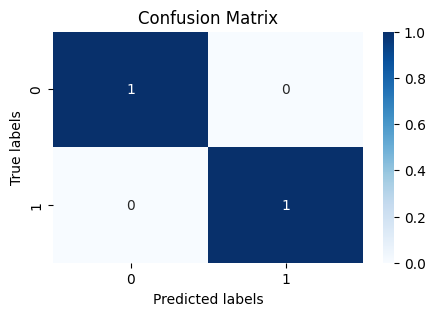

In [ ]:
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')  # 'g' for integer formatting
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()